## Exploratory Data Analysis / Feature Extraction

In [1]:
from os import walk
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# parse the file names into a numpy matrix, each row represents one file.
RAW_DATA_PATH = '../data/raw'
dirs = []
for (dirpath, dirnames, _) in walk(RAW_DATA_PATH):
    for d in dirnames:
        if d.startswith("Actor"):
            dirs.append(dirpath+'/'+d)
    break
    
all_files = []
for actor in dirs:
    for(_,_,files) in walk(actor):
        all_files+=[i.split('.')[0].split('-') for i in files]
        break
all_files = [[int(i) - 1 for i in row] for row in all_files]

files = np.array(all_files)
print(files)

[[ 2  0  4 ...  1  0 15]
 [ 2  0  5 ...  1  1 15]
 [ 2  0  5 ...  0  1 15]
 ...
 [ 2  0  1 ...  0  0  7]
 [ 2  0  1 ...  1  0  7]
 [ 2  0  0 ...  1  1  7]]


In [3]:
def matrix_to_filename(matrix, RAW_DATA_PATH):
    filepaths = []
    for row in matrix:
        filename = ''
        for col in row:
            filename+=str(col+1).zfill(2)
            filename+='-'
        filename = filename[:-1]
        filename+='.wav'
        filepaths.append(RAW_DATA_PATH+'/Actor_'+str(row[6]+1).zfill(2)+'/'+filename)
        # print(filename)
    return filepaths
def plot_counts(files):
    print(f"Total number of files {files.shape[0]}")

    labels = [['full-AV', 'video-only', 'audio-only'],
             ['speech', 'song'],
             ['neutral' , 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust','surprised'],
             ['normal', 'strong'],
             ['Kids are talking by the door', 'Dogs are sitting by the door'],
             ['1st repetition', '2nd repetition'],
             ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']
             ]
    titles = ['Modality', 'Vocal channel', 'Emotion', 'Emotional intensity' ,'Statement','Repetition' ,'Actor']
    
    fig, ax = plt.subplots(2, 4, figsize=(20, 10)) 
    inds = [(0,0), (0,1), (0,2), (0,3), (1,0), (1,1), (1,2), (1,3)]
    for i in range(7):
        unique, counts = np.unique(files[:, i], return_counts = True)
        unique = np.array(labels[i])[unique]
        ax[inds[i]].bar(unique, counts)
        ax[inds[i]].set_title(titles[i])
    ax[inds[-1]].axis('off')
    plt.suptitle("Count Plots")
    plt.tight_layout()
    plt.show()

Total number of files 1440


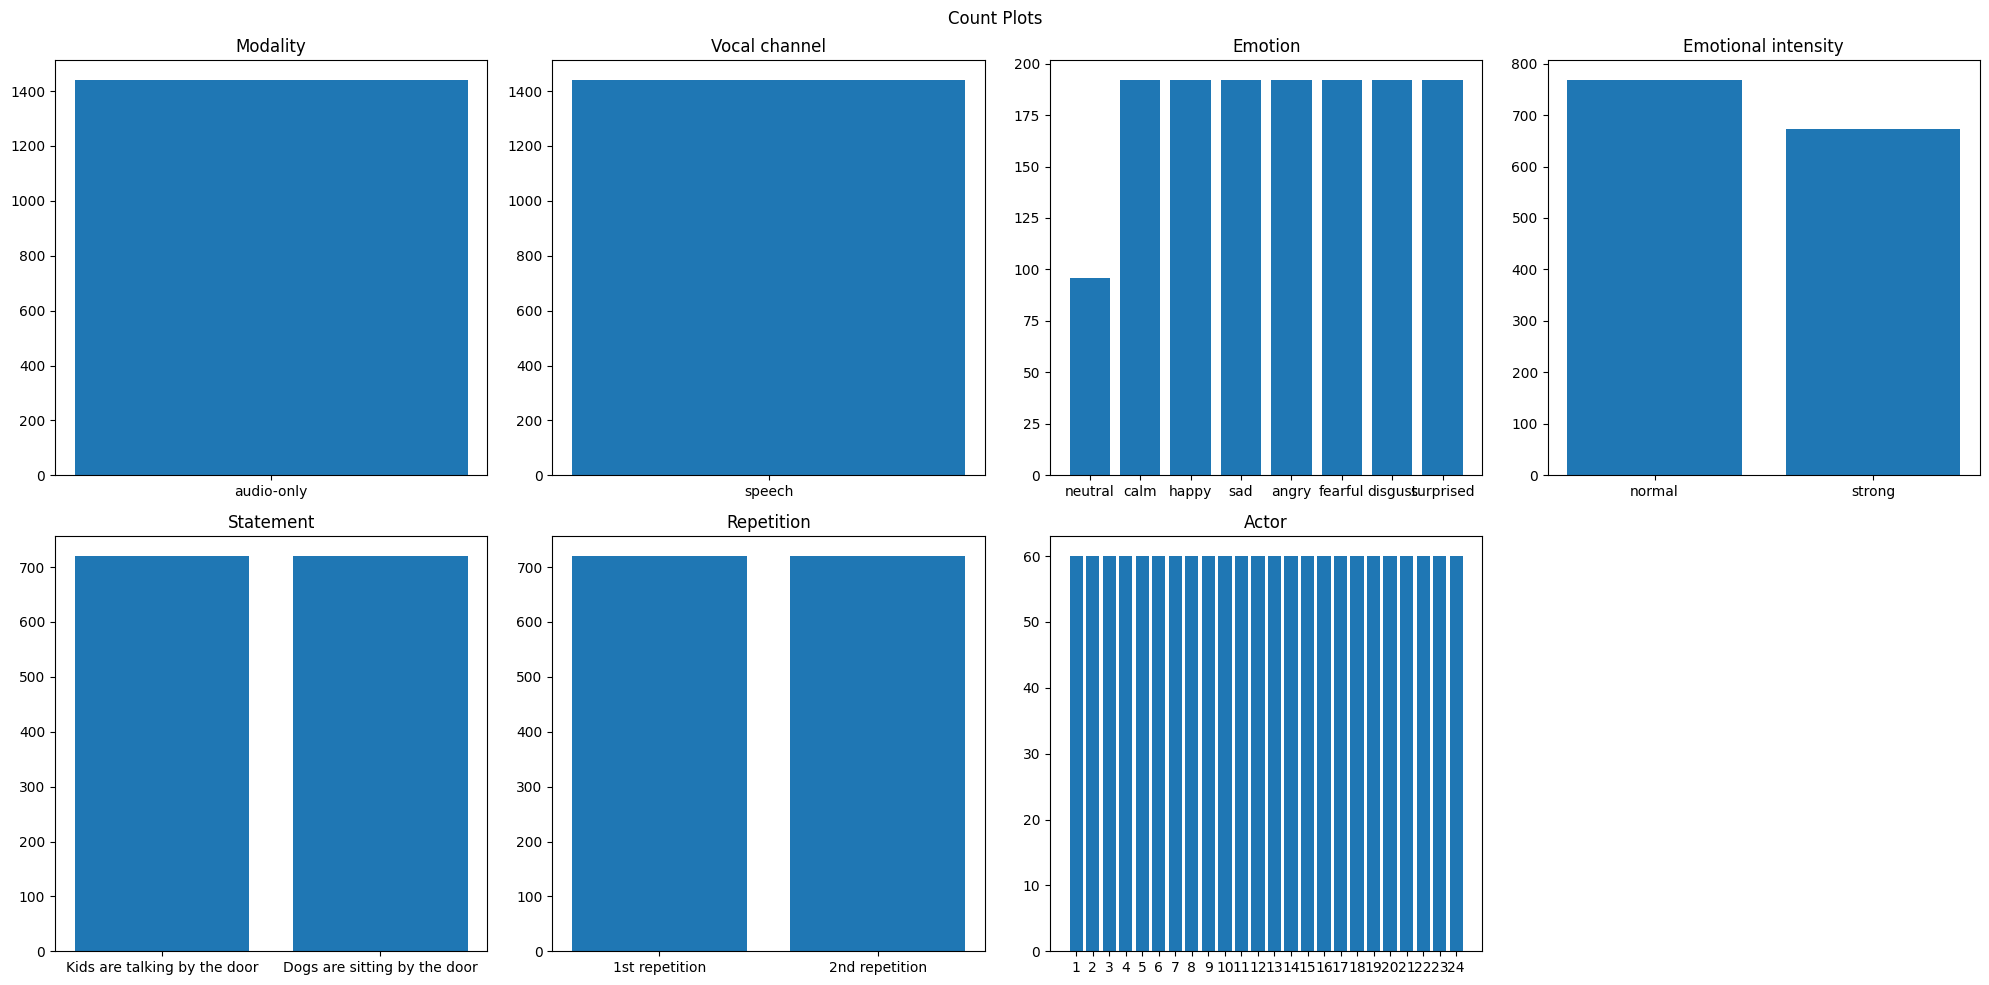

In [4]:
plot_counts(files)

Total number of files 96


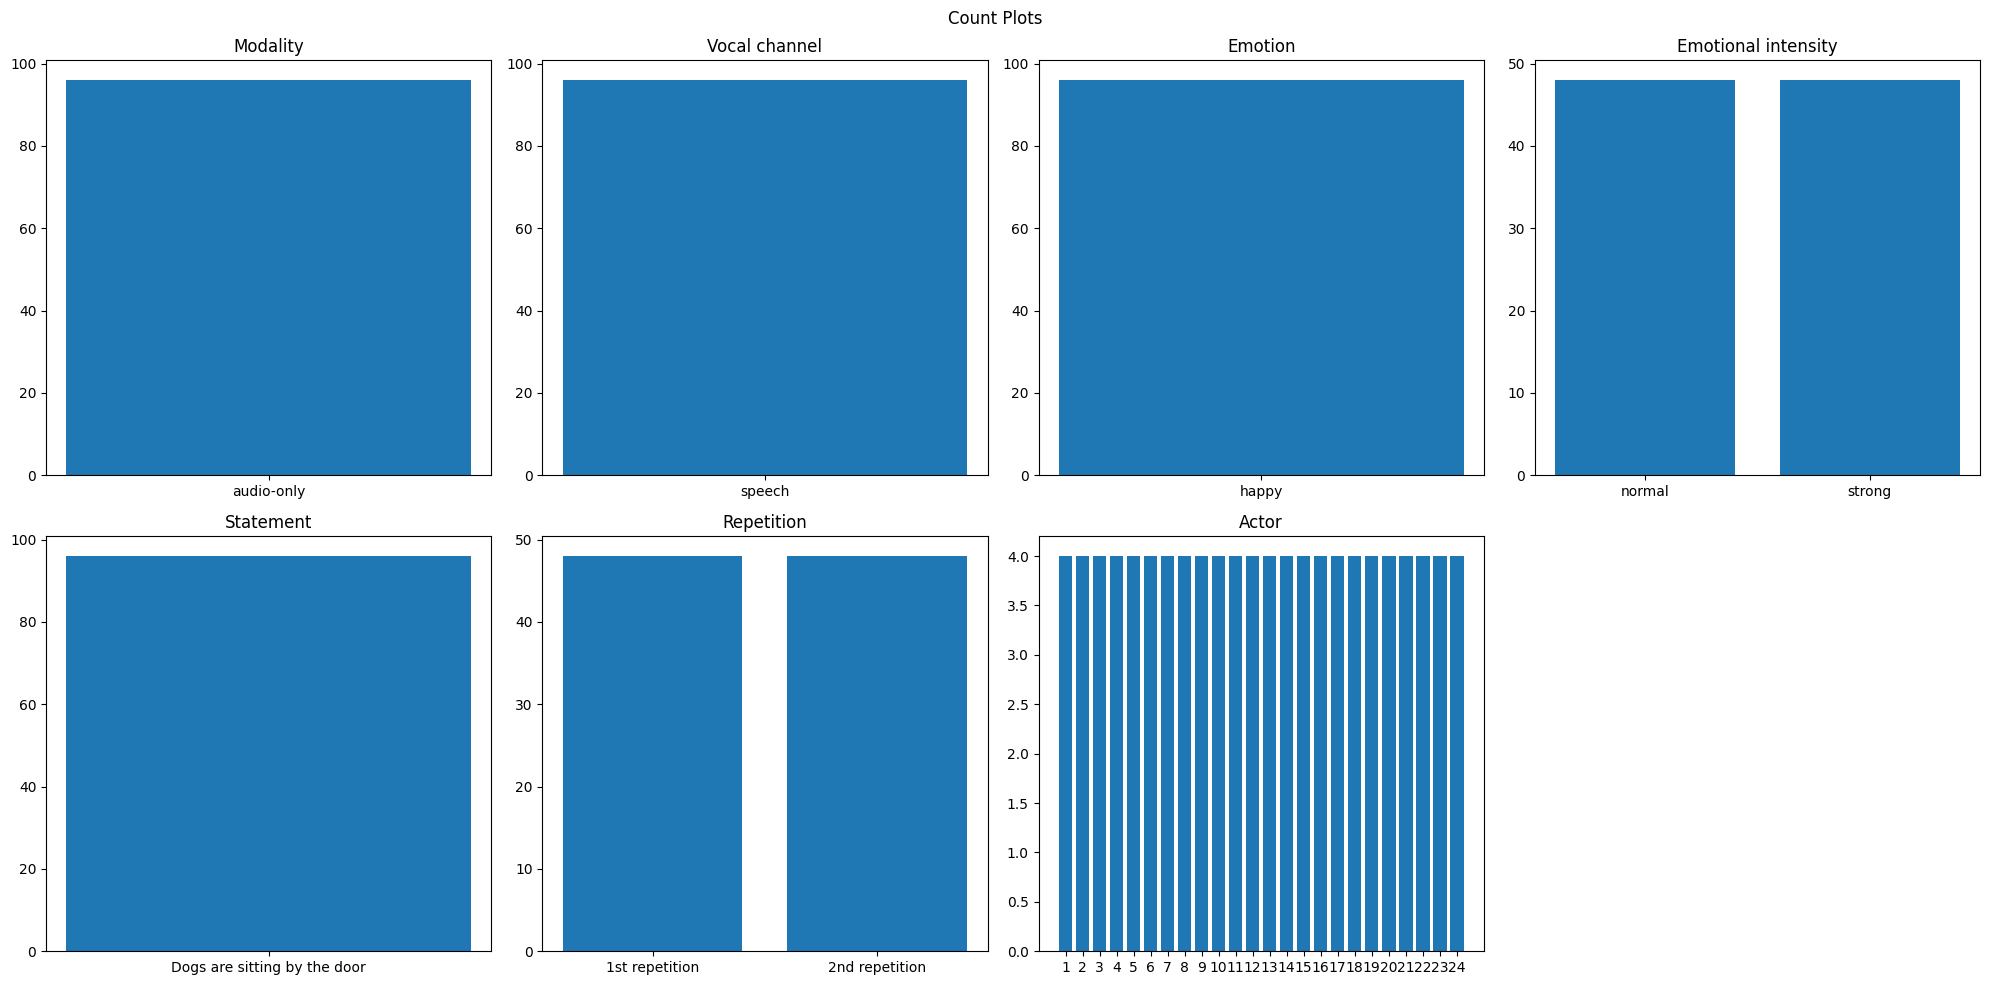

In [5]:
# plot only happy files with "dogs are sitting by the door"
mask = (files[:, 2] == 2 )
mask2 = (files[:, 4] == 1 )
extracted = files[mask&mask2]
plot_counts(extracted)

In [6]:
# average audio of all happy saying "dogs are sitting by the door"
import librosa 
import librosa.display
from IPython.display import Audio, Image, display

filepaths = matrix_to_filename(extracted, RAW_DATA_PATH)
all_samples = []
for file in filepaths:
    samples, sample_rate = librosa.load(file, sr=None)
    all_samples.append(samples)

mn = min(len(row) for row in all_samples)
print(mn)

truncated_data = [row[:mn] for row in all_samples]
average_audio = np.mean(np.array(truncated_data), axis = 0)
Audio(data=average_audio, rate=48000)



150551


### Spectral Rolloff - Frequency below which 99% of the energy lies under


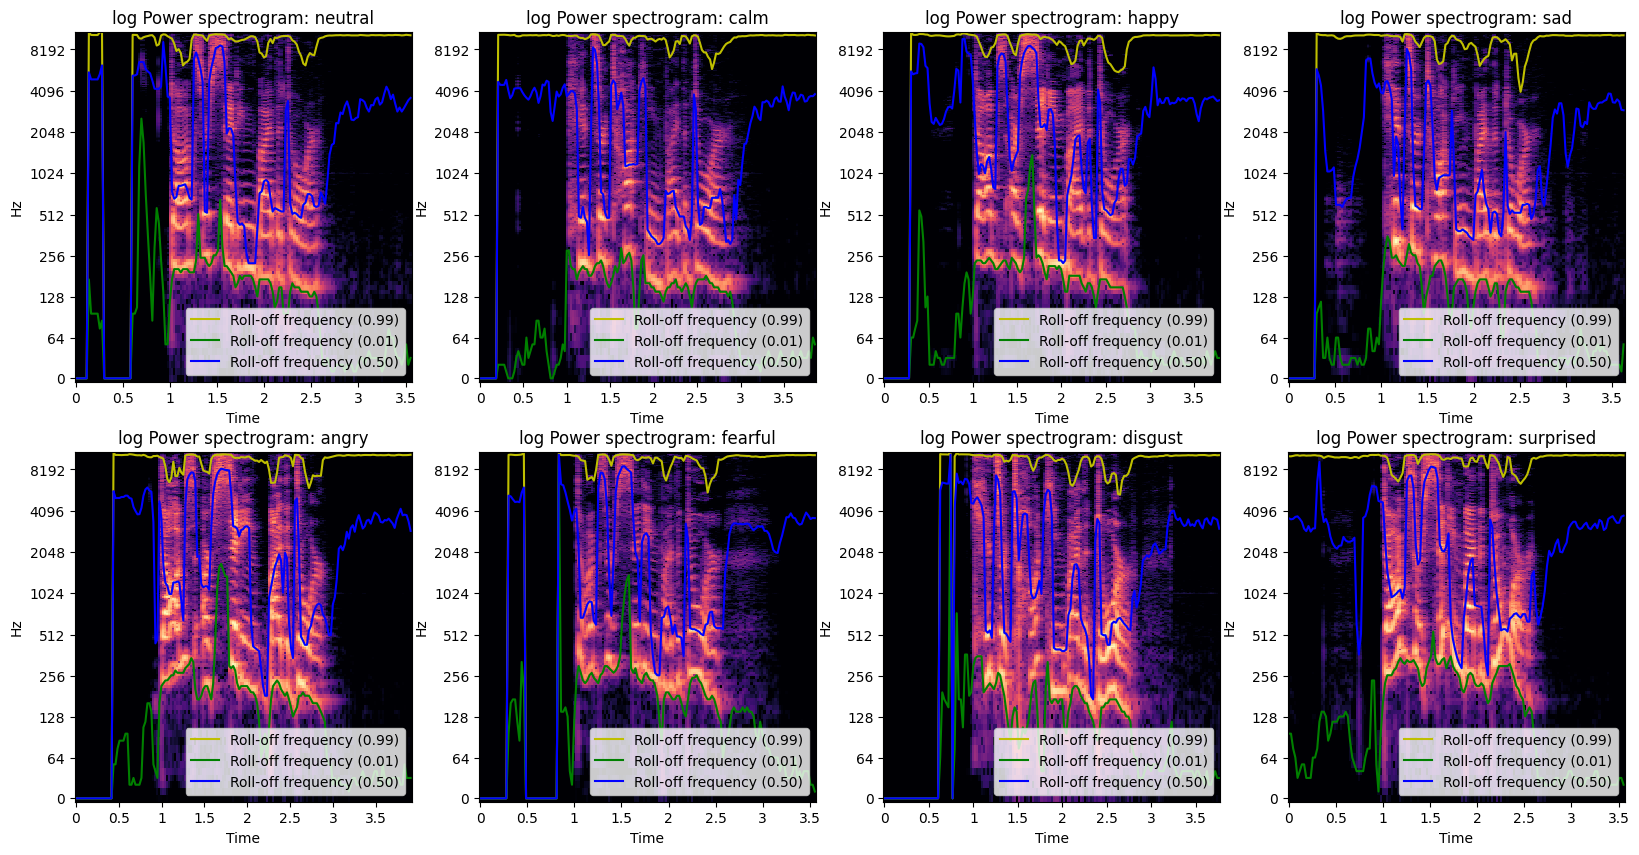

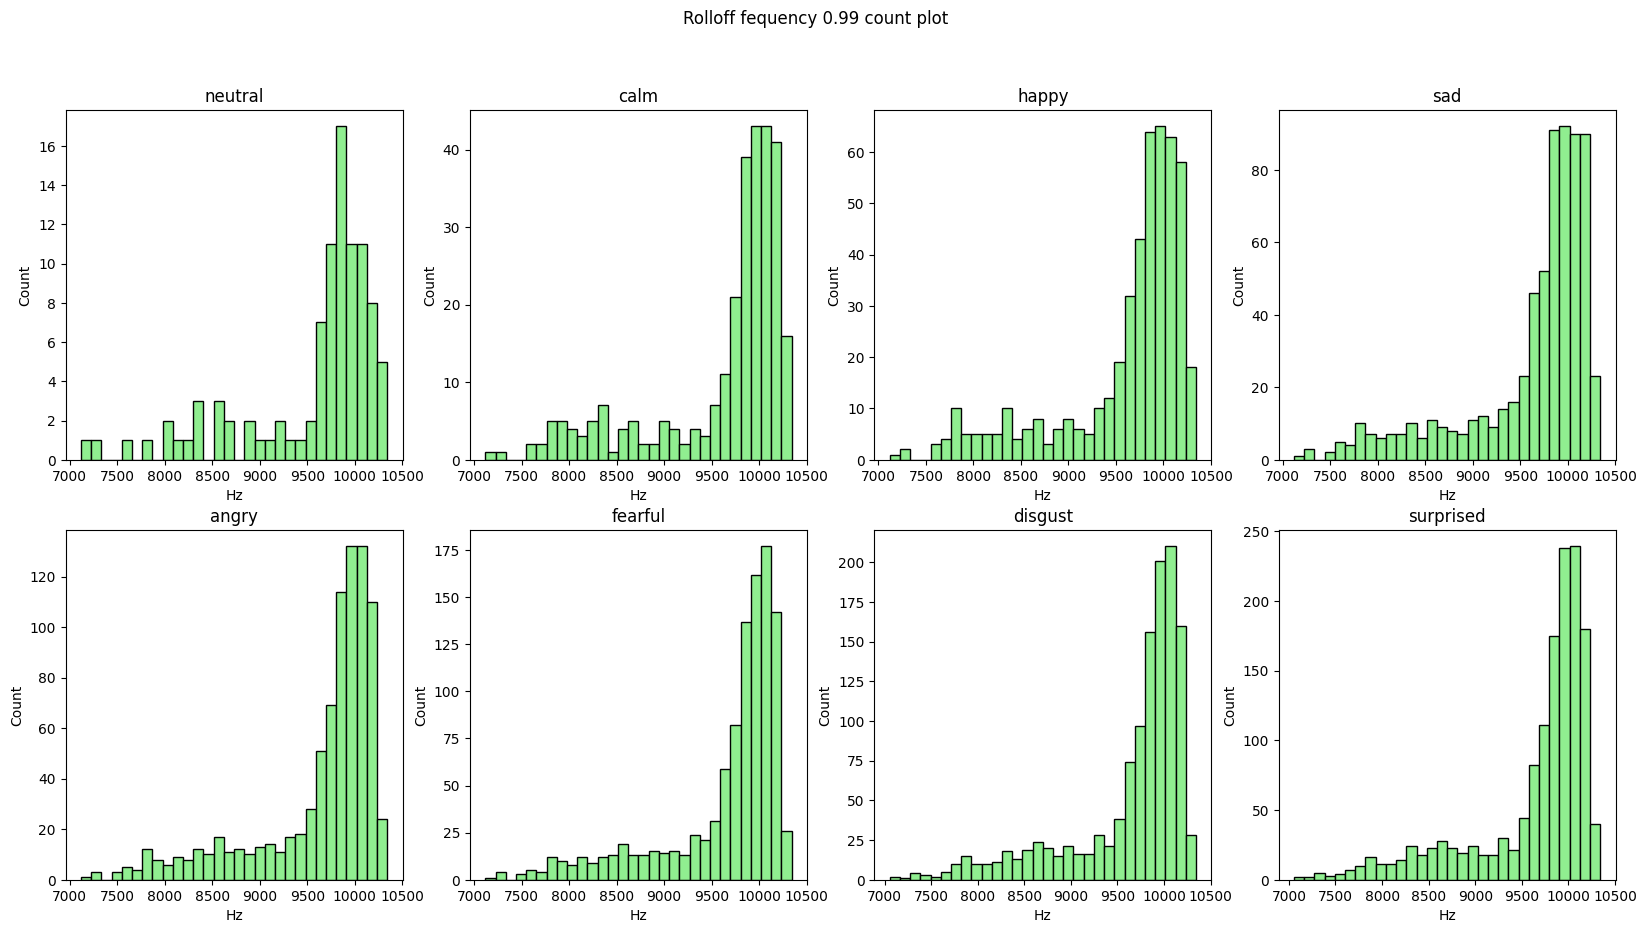

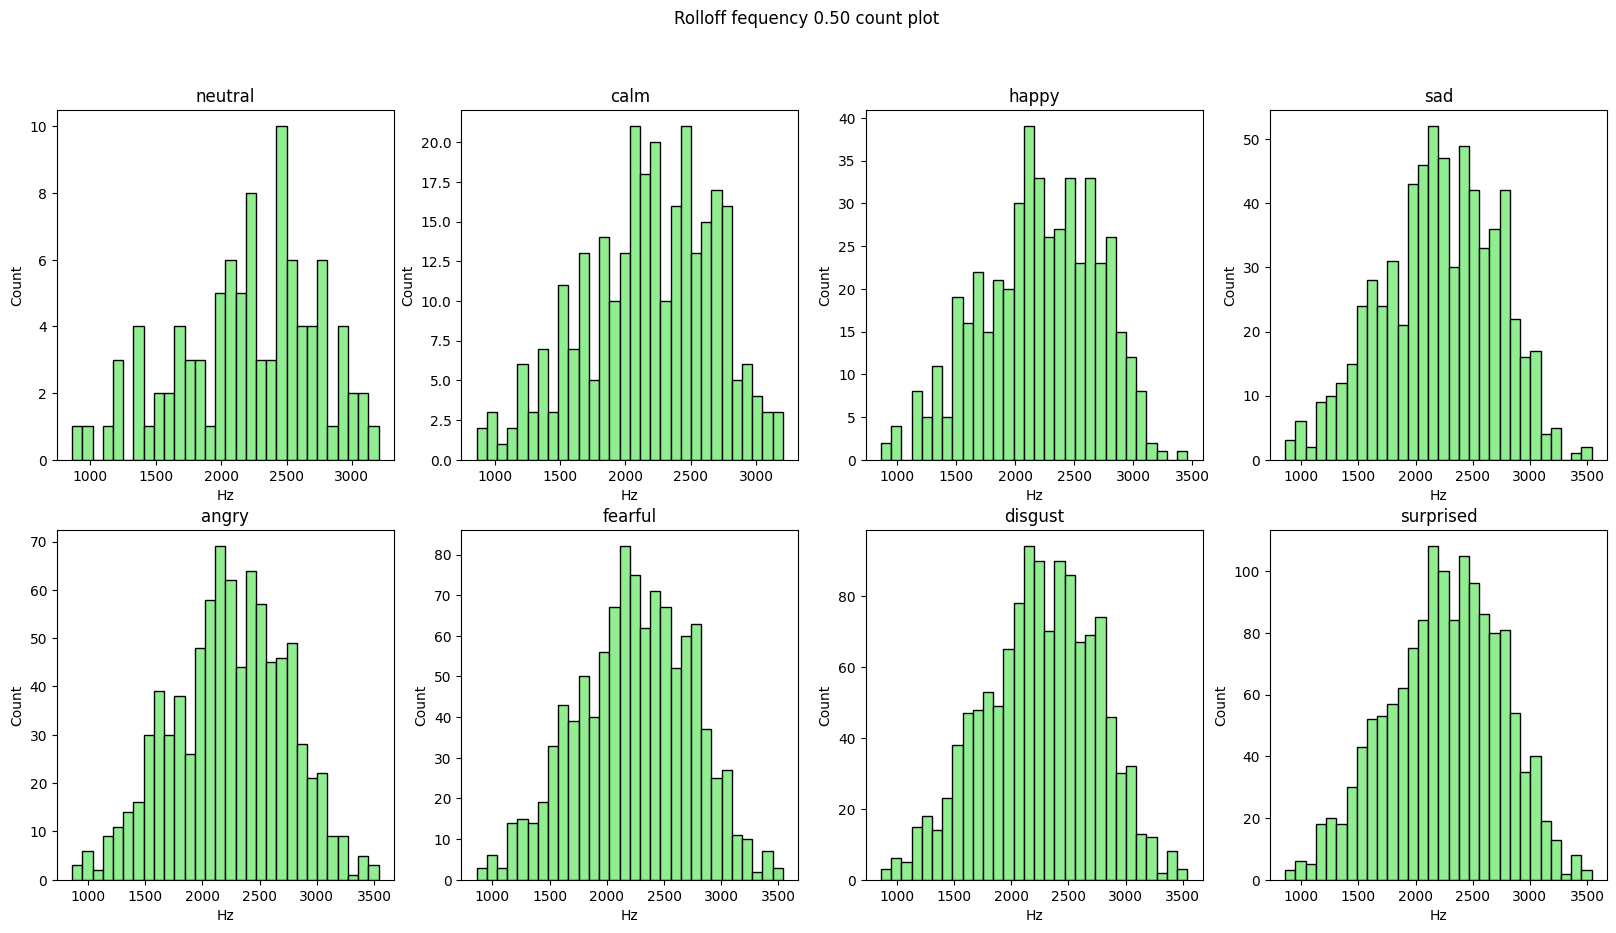

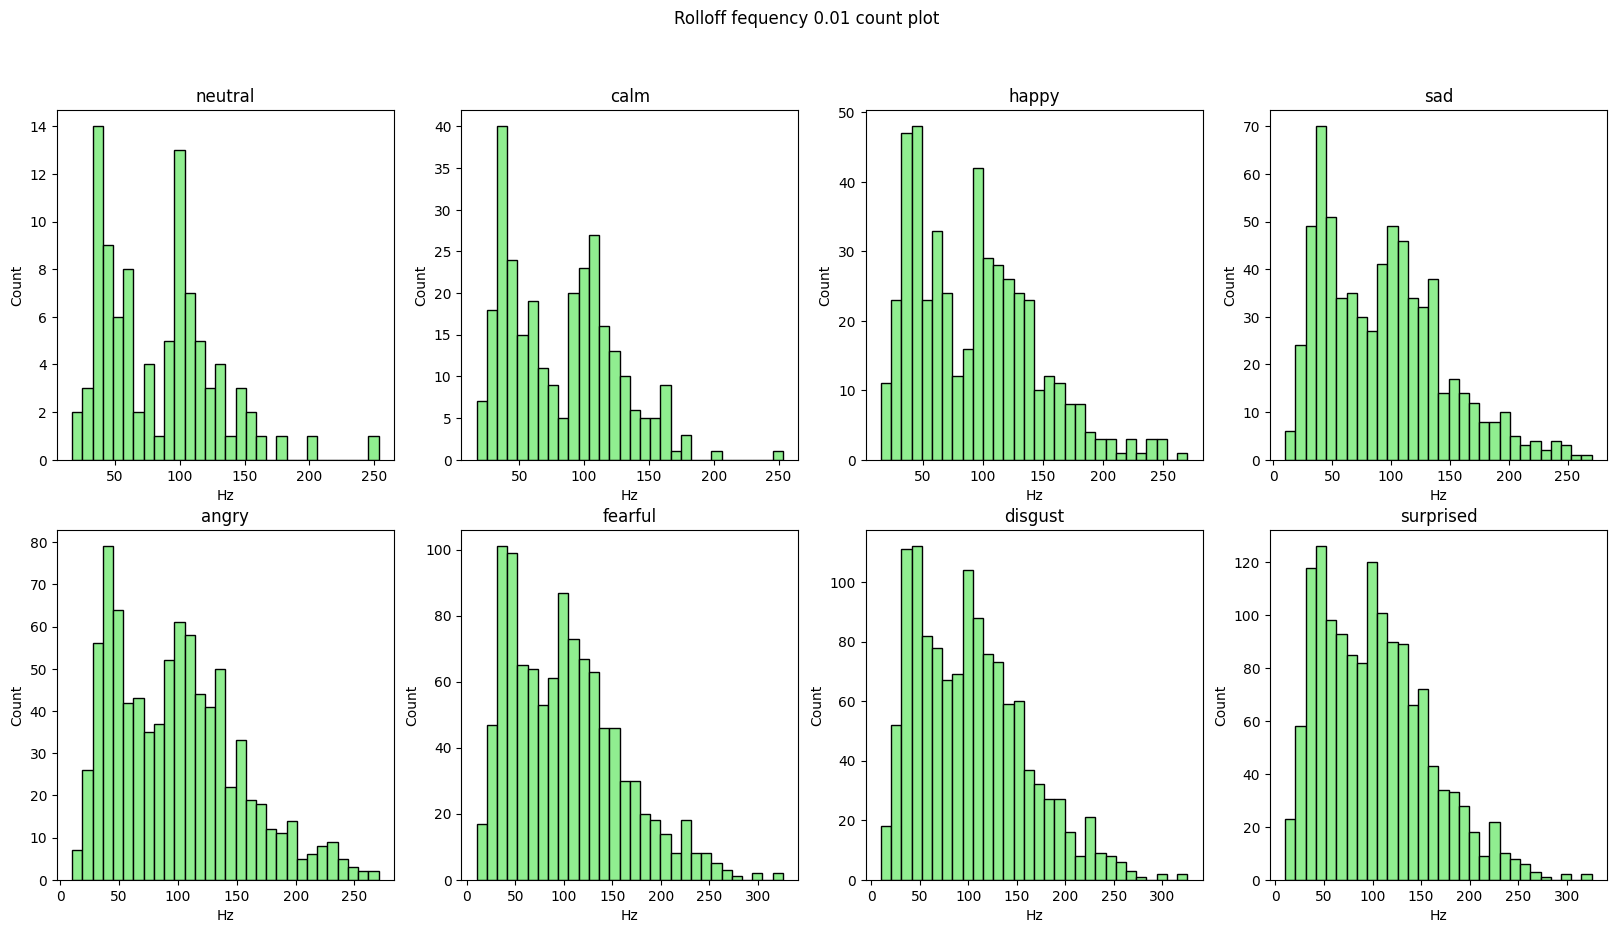

In [50]:
def truncate(arrays):
    mn = min(len(row) for row in all_samples)
    truncated_data = [row[:mn] for row in all_samples]
    avg = np.mean(np.array(truncated_data), axis = 0)
    return avg
emotions = ['neutral' , 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust','surprised']
inds = [(0,0), (0,1), (0,2), (0,3), (1,0), (1,1), (1,2), (1,3)]

fig, ax = plt.subplots(2, 4, figsize=(20, 10)) 
fig2, ax2 = plt.subplots(2, 4, figsize=(20, 10)) 
fig3, ax3 = plt.subplots(2, 4, figsize=(20, 10)) 
fig4, ax4 = plt.subplots(2, 4, figsize=(20, 10)) 

all_rolloffs =  []
all_rolloffs_50 =  []
all_rolloffs_1 =  []

for i in range(8):
    mask = (files[:, 2] == i )
    filepaths = matrix_to_filename(files[mask], RAW_DATA_PATH)

    graph = False
    for path in filepaths:
            
        y, sr = librosa.load(path)
        S, _ = librosa.magphase(librosa.stft(y))
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.99)
        rolloff_half = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.50)
        rolloff_min = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.01)

        all_rolloffs.append(np.mean(rolloff))
        all_rolloffs_50.append(np.mean(rolloff_half))
        all_rolloffs_1.append(np.mean(rolloff_min))

        S, _ = librosa.magphase(librosa.stft(y))
        
        if(not graph):      
            librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time', ax=ax[inds[i]])
        
            ax[inds[i]].plot(librosa.times_like(rolloff), rolloff[0], color='y', label='Roll-off frequency (0.99)')
            ax[inds[i]].plot(librosa.times_like(rolloff), rolloff_min[0], color='g', label='Roll-off frequency (0.01)')
            ax[inds[i]].plot(librosa.times_like(rolloff), rolloff_half[0], color='b', label='Roll-off frequency (0.50)')
            
            ax[inds[i]].legend(loc='lower right')
            ax[inds[i]].set(title=f'log Power spectrogram: {emotions[i]}')
            graph = True

            
    data =  np.array(all_rolloffs)
    
    fig2.suptitle("Rolloff fequency 0.99 count plot")
    ax2[inds[i]].hist(data, bins=30, edgecolor='black', color='lightgreen')
    ax2[inds[i]].set_xlabel("Hz")
    ax2[inds[i]].set_ylabel("Count")
    ax2[inds[i]].set_title(emotions[i])

    data =  np.array(all_rolloffs_50)
    fig3.suptitle("Rolloff fequency 0.50 count plot")
    ax3[inds[i]].hist(data, bins=30, edgecolor='black', color='lightgreen')
    ax3[inds[i]].set_xlabel("Hz")
    ax3[inds[i]].set_ylabel("Count")
    ax3[inds[i]].set_title(emotions[i])

    data =  np.array(all_rolloffs_1)
    fig4.suptitle("Rolloff fequency 0.01 count plot")
    ax4[inds[i]].hist(data, bins=30, edgecolor='black', color='lightgreen')
    ax4[inds[i]].set_xlabel("Hz")
    ax4[inds[i]].set_ylabel("Count")
    ax4[inds[i]].set_title(emotions[i])
plt.show()